In [1]:
import numpy as np
from matplotlib import pyplot as plt
# from skimage.color import rgb2gray
# from skimage.data import stereo_motorcycle, vortex
# from skimage.transform import warp
# from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage import io
import ants
import scipy.ndimage as ndimage
from glob import glob
import SimpleITK as sitk

In [131]:
im0 = io.imread('./_Image_09.vsi - 20x.tif')
im1 = io.imread('./_Image_10.vsi - 20x.tif')
im2 = io.imread('./_Image_11.vsi - 20x.tif')
im3 = io.imread('./_Image_12.vsi - 20x.tif')


im_list = sorted(glob('./*.tif'))
# im_idx = [im_str.split('.vsi')[0].split('_Image_')[1] for im_str in im_list]
# im_list = ['./_Image_09.vsi - 20x.tif','./_Image_10.vsi - 20x.tif','./_Image_11.vsi - 20x.tif','./_Image_12.vsi - 20x.tif']

# im_sort_idx = np.argsort(np.array(im_idx).astype(int))

# im_list = im_list[im_sort_idx]
# im_idx = im_idx[im_sort_idx]

def compute_reg(fixed,moving):
    mytx = ants.registration(fixed,moving,type_of_transform='Rigid',reg_iterations=(100,100,100),aff_random_sampling_rate=.5, verbose=False)
    mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving,
                                           transformlist=mytx['fwdtransforms'],interpolation='nearest')
    return {'tx':mytx, 'warped_moving':mywarpedimage}

def ants_reg_2d(fixed,moving):
    mytx = ants.registration(fixed,moving,type_of_transform='Rigid',reg_iterations=(100,100,100),aff_random_sampling_rate=.5, verbose=False)
    mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving,
                                           transformlist=mytx['fwdtransforms'],interpolation='nearest')
    return mywarpedimage

def read_tiff_image(inputImageFileName):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("TIFFImageIO")
    reader.SetFileName(inputImageFileName)
    image = reader.Execute()
    return image

def write_image(image, outputImageFileName):
    writer = sitk.ImageFileWriter()
    writer.SetFileName(outputImageFileName)
    writer.Execute(image)
    print(f"Image written to: {outputImageFileName}")

def sitk_reg_2d(fixed_image,moving_image):
    #from: https://github.com/CoBrALab/RABIES/blob/788e22d4e0da41a5cc432a2f3a66c84362fae2ad/rabies/preprocess_pkg/hmc.py#L193
    # function for 2D registration
    dimension = 2
    
    # initial_transform = sitk.Transform(dimension, sitk.sitkIdentity)
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)    

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=32)
    registration_method.SetMetricSamplingStrategy(registration_method.NONE)
    registration_method.SetMetricSamplingPercentage(0.5)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=.05, numberOfIterations=1000, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[6, 4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[3, 2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOff() #we want this in voxel space

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))
    return final_transform


def compute_slicewise_reg(im_list, fname_fixed):
    xfm_im_list = [] #list of transformed images 
    xfm_list = [] #list of all transforms
    for idx,fname_moving in enumerate(im_list):
        print(f"{idx}",end=': ')
        im1=io.imread(fname_moving)
        moving = ants.from_numpy(im1)
        if idx == 0: #first time, so moving goes to fixed as is
            im0=io.imread(fname_fixed)
            fixed = ants.from_numpy(im0) #convert from standard type to antsImage type
            # xfm_im_list.append(fixed)
        else: #we just update what fixed is
            fixed = res['warped_moving']
            fname_fixed = im_list[idx-1] #update the previous one

        print(f"{fname_fixed} <- {fname_moving}")
        res = compute_reg(fixed,moving)

        xfm_list.append(res['tx'])
        xfm_im_list.append(res['warped_moving']) #transformed images
    return {'xfm_list':xfm_list,'xfm_im_list':xfm_im_list}

def generate_3d_from_reg(reg_ims_list,slice_position_idxs,through_plane_spacing=5,final_vox_spacing=(10,10,10)):
    num_slices_tot = np.max(slice_position_idxs)+1 #total number, even if we are missing some
    # all_slices_idx = np.arange(num_slices_tot)
    d_out = np.zeros((reg_ims_list[0].shape + (num_slices_tot*through_plane_spacing,)))
    print("Adding slice at position index: ")
    for slice_pos in slice_position_idxs:
        print(slice_pos,end=',')
        d_out[...,slice_pos*through_plane_spacing:slice_pos*through_plane_spacing+through_plane_spacing] = reg_ims_list[slice_pos].numpy()[...,np.newaxis]
    im_out = ants.from_numpy(d_out)
    im_out.set_spacing(final_vox_spacing)
    return im_out
    

In [132]:
#for now we just assume that the file numbers refer to the correct slices (THEY DO NOT, YOU WILL NEED TO DO A LOOKUP based on the spreadsheet b/c the ordering is wrong in some!)
max_img_num = np.array([im_str.split('.vsi')[0].split('_Image_')[1] for im_str in im_list]).astype(int).max() #max of standard images
im_list_len = len(im_list)

if im_list_len > max_img_num:
    max_img_num = im_list_len
print(f"total number of images to register: {max_img_num}")

#determine where the largest slice is, this will be the reference for all initial registration
max_sz = (0,0)
max_sz_idx = 0
for idx,im in enumerate(im_list):
    sz = io.imread(im).shape
    if sz > max_sz:
        max_sz = sz
        max_sz_idx = idx
        
reverse_reg_im_list = im_list[0:max_sz_idx][::-1] #reverse the order of the images that comes prior to the initial target slice so that the reg will go in the correct order (you will need to reverse it before creating the output file)
forward_reg_im_list = im_list[max_sz_idx+1:] #we skip the one that will be the initial target
init_fixed = im_list[max_sz_idx]


total number of images to register: 110


3828837.0
3134182.2


3834443.0

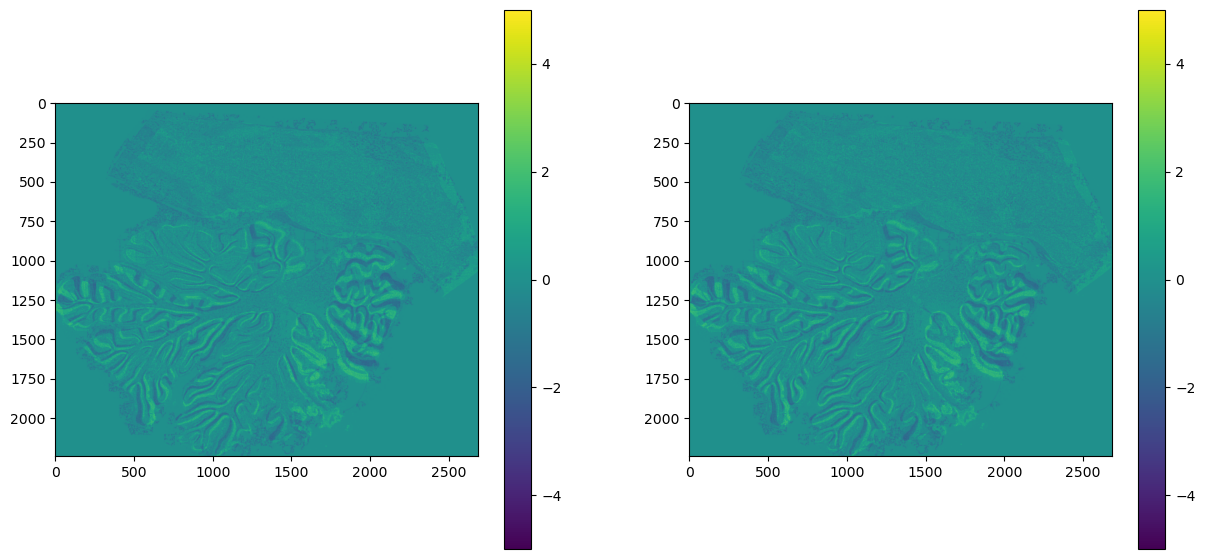

In [134]:
fixed_image = read_tiff_image(init_fixed)
moving_image = read_tiff_image(reverse_reg_im_list[0])
xfm = sitk_reg_2d(fixed_image,moving_image)

ants_warped = ants_reg_2d(ants.from_numpy(io.imread(init_fixed)),ants.from_numpy(io.imread(reverse_reg_im_list[0])))

moving_resampled = sitk.Resample(moving_image, fixed_image, xfm,
                                         sitk.sitkNearestNeighbor, 0.0, moving_image.GetPixelID())
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sitk_diff = sitk.GetArrayFromImage(moving_resampled) - sitk.GetArrayFromImage(fixed_image)
plt.imshow(sitk_diff,vmin=-5,vmax=5), plt.colorbar()
plt.subplot(1,2,2)
ants_diff = ants_warped.numpy() - io.imread(init_fixed)
plt.imshow(ants_diff,vmin=-5,vmax=5), plt.colorbar()
print((sitk_diff**2).sum())
print((ants_diff**2).sum())
# plt.figure()
# plt.plot(np.abs(sitk_diff.ravel()) - np.abs(ants_diff.ravel()),',')

3834443.0#best so far, w/ sitk

In [103]:
if max_sz_idx != 0: #if we have some images prior to the largest image
    #do reverse reg first
    revese_reg_ims = compute_slicewise_reg(reverse_reg_im_list, init_fixed)

0: ./_Image_06.vsi - 20x.tif <- ./_Image_05.vsi - 20x.tif
1: ./_Image_05.vsi - 20x.tif <- ./_Image_02.vsi - 20x.tif
2: ./_Image_02.vsi - 20x.tif <- ./_Image_01.vsi - 20x.tif


In [5]:
#now forward regs
forward_reg_ims = compute_slicewise_reg(forward_reg_im_list[0:20], init_fixed)

0: ./_Image_06.vsi - 20x.tif <- ./_Image_07.vsi - 20x.tif
1: ./_Image_07.vsi - 20x.tif <- ./_Image_09.vsi - 20x.tif
2: ./_Image_09.vsi - 20x.tif <- ./_Image_10.vsi - 20x.tif
3: ./_Image_10.vsi - 20x.tif <- ./_Image_11.vsi - 20x.tif
4: ./_Image_11.vsi - 20x.tif <- ./_Image_12.vsi - 20x.tif
5: ./_Image_12.vsi - 20x.tif <- ./_Image_14.vsi - 20x.tif
6: ./_Image_14.vsi - 20x.tif <- ./_Image_15.vsi - 20x.tif
7: ./_Image_15.vsi - 20x.tif <- ./_Image_16.vsi - 20x.tif
8: ./_Image_16.vsi - 20x.tif <- ./_Image_17.vsi - 20x.tif
9: ./_Image_17.vsi - 20x.tif <- ./_Image_19.vsi - 20x.tif
10: ./_Image_19.vsi - 20x.tif <- ./_Image_20.vsi - 20x.tif
11: ./_Image_20.vsi - 20x.tif <- ./_Image_21.vsi - 20x.tif
12: ./_Image_21.vsi - 20x.tif <- ./_Image_22.vsi - 20x.tif
13: ./_Image_22.vsi - 20x.tif <- ./_Image_23.vsi - 20x.tif
14: ./_Image_23.vsi - 20x.tif <- ./_Image_24.vsi - 20x.tif
15: ./_Image_24.vsi - 20x.tif <- ./_Image_25.vsi - 20x.tif
16: ./_Image_25.vsi - 20x.tif <- ./_Image_27.vsi - 20x.tif
17: ./_

In [6]:
# TODO: change to be correct version for final, just trying this out here
# get the indices of the image slices, custom renumbering of last as the filename is different

im_idx = [im_str.split('.vsi')[0].split('_Image_')[1] for im_str in im_list]
im_idx = np.array(im_idx).astype(int)
im_idx[-1] = im_idx[-2]+1
im_idx

array([  1,   2,   5,   6,   7,   9,  10,  11,  12,  14,  15,  16,  17,
        19,  20,  21,  22,  23,  24,  25,  27,  28,  30,  31,  32,  33,
        35,  36,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  61,
        62,  62,  63,  64,  64,  65,  65,  66,  66,  67,  68,  68,  69,
        69,  70,  70,  71,  72,  72,  73,  73,  74,  75,  75,  76,  76,
        77,  78,  79,  80,  80,  81,  81,  82,  83,  83,  84,  85,  85,
        86,  86,  87,  89,  90,  90,  91,  91,  92,  93,  93,  94,  94,
        95,  95,  98,  99,  99, 100])

In [10]:
len(revese_reg_ims['xfm_im_list'][::-1] + [init_fixed] + forward_reg_ims['xfm_im_list'])

24

In [ ]:
#now generate your full image for output
#we first need to determine where each slice should be, this should be based on the xls lookup but will be approximate here
im_out = generate_3d_from_reg(revese_reg_ims['xfm_im_list'][::-1] + [init_fixed] + forward_reg_ims['xfm_im_list'], im_idx)
im_out.to_filename('./xxx_all.nii.gz')

Adding slice at position index: 
1,

In [142]:
xfm_im_list = []
xfm_list = []
for idx in np.arange(len(im_list)-1):
    print(f"{idx}",end=': ')
    fname_moving = im_list[idx+1]
    im1=io.imread(fname_moving)
    moving = ants.from_numpy(im1)
    fname_fixed = im_list[idx]
    
    if idx == 0: #first time, so moving goes to fixed as is
        im0=io.imread(fname_fixed)
        fixed = ants.from_numpy(im0) #convert from standard type to antsImage type
        xfm_im_list.append(fixed)
    else: #we just update what fixed is
        fixed = mywarpedimage

    print(f"{fname_fixed} <- {fname_moving}")
    mytx = ants.registration(fixed,moving,type_of_transform='Rigid',reg_iterations=(100,100,100),aff_random_sampling_rate=.5, verbose=False)
    mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving,
                                           transformlist=mytx['fwdtransforms'],interpolation='nearest')
    xfm_list.append(mytx)
    xfm_im_list.append(mywarpedimage) #append what our target is
    



0: ./_Image_09.vsi - 20x.tif <- ./_Image_10.vsi - 20x.tif
1: ./_Image_10.vsi - 20x.tif <- ./_Image_11.vsi - 20x.tif
2: ./_Image_11.vsi - 20x.tif <- ./_Image_12.vsi - 20x.tif


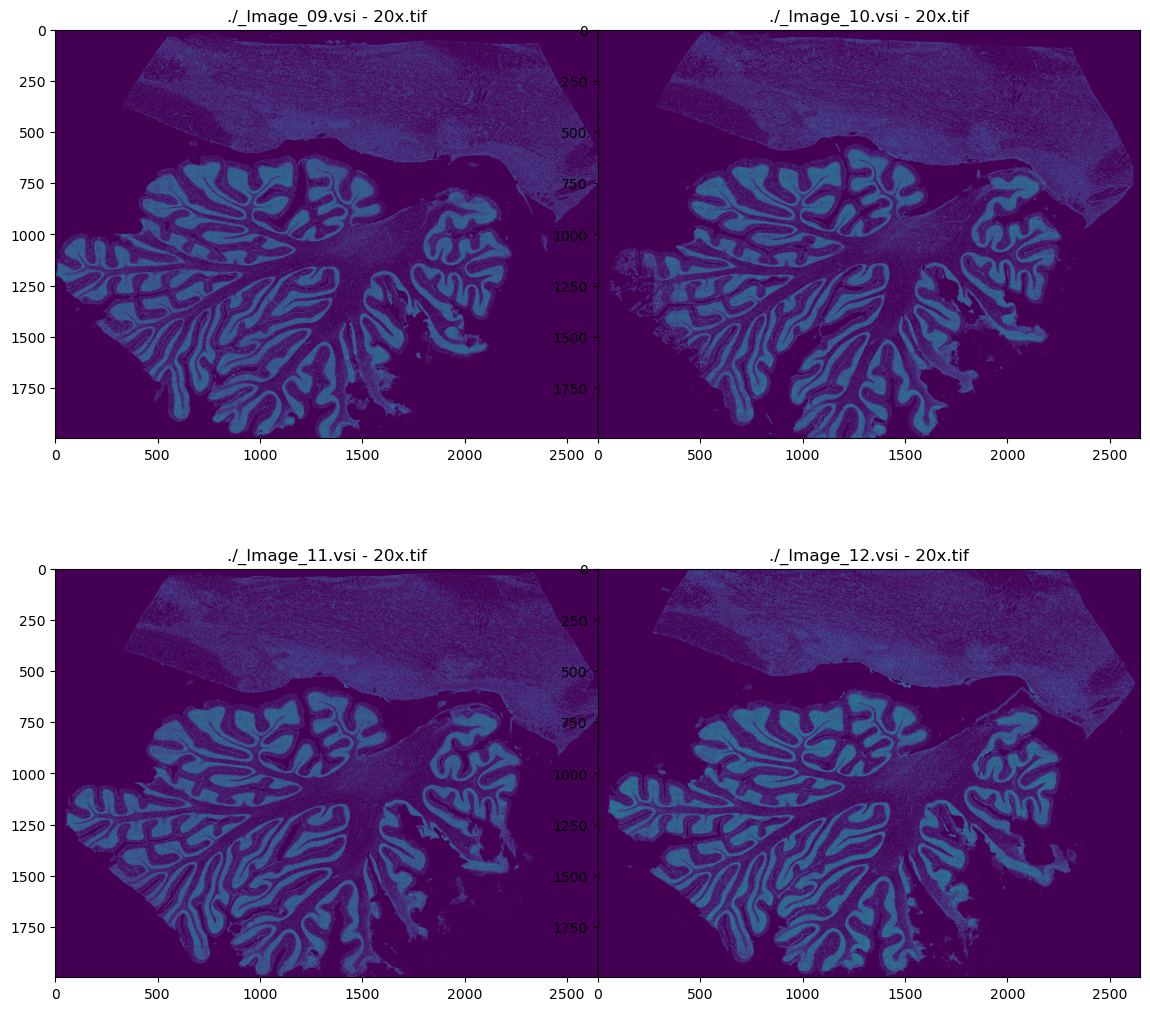

In [146]:
num_rows = np.ceil(len(xfm_im_list)/2.).astype(int)
plt.figure(figsize=(7*num_rows,7*num_rows))

for idx,im in enumerate(xfm_im_list):
    plt.subplot(num_rows,num_rows,idx+1)
    plt.imshow(im.numpy())
    plt.title(im_list[idx])
plt.subplots_adjust(wspace=0, hspace=0)

In [147]:
d_out = np.zeros((xfm_im_list[0].shape+(len(xfm_im_list),)))
for idx,im in enumerate(xfm_im_list):
    d_out[...,idx] = im.numpy()


In [151]:
im_out = ants.from_numpy(d_out)
im_out.set_spacing((10,10,50))
ants.image_write(im_out,'./test_Rigid.nii.gz')


In [152]:
ants.image_write(ants.smooth_image(im_out,(10,10,2)),'./test_Rigid_s2.nii.gz')

Signature: im_out.set_spacing(new_spacing)
Docstring:
Set image spacing

Arguments
---------
new_spacing : tuple or list
    updated spacing for the image.
    should have one value for each dimension

Returns
-------
None
File:      /opt/quarantine/miniforge/envs/py3p9/lib/python3.9/site-packages/ants/core/ants_image.py
Type:      method

In [83]:
print(mytx)

{'warpedmovout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2191, 2713)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'warpedfixout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2141, 2594)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'fwdtransforms': ['/tmp/tmpa619l8u70GenericAffine.mat'], 'invtransforms': ['/tmp/tmpa619l8u70GenericAffine.mat']}


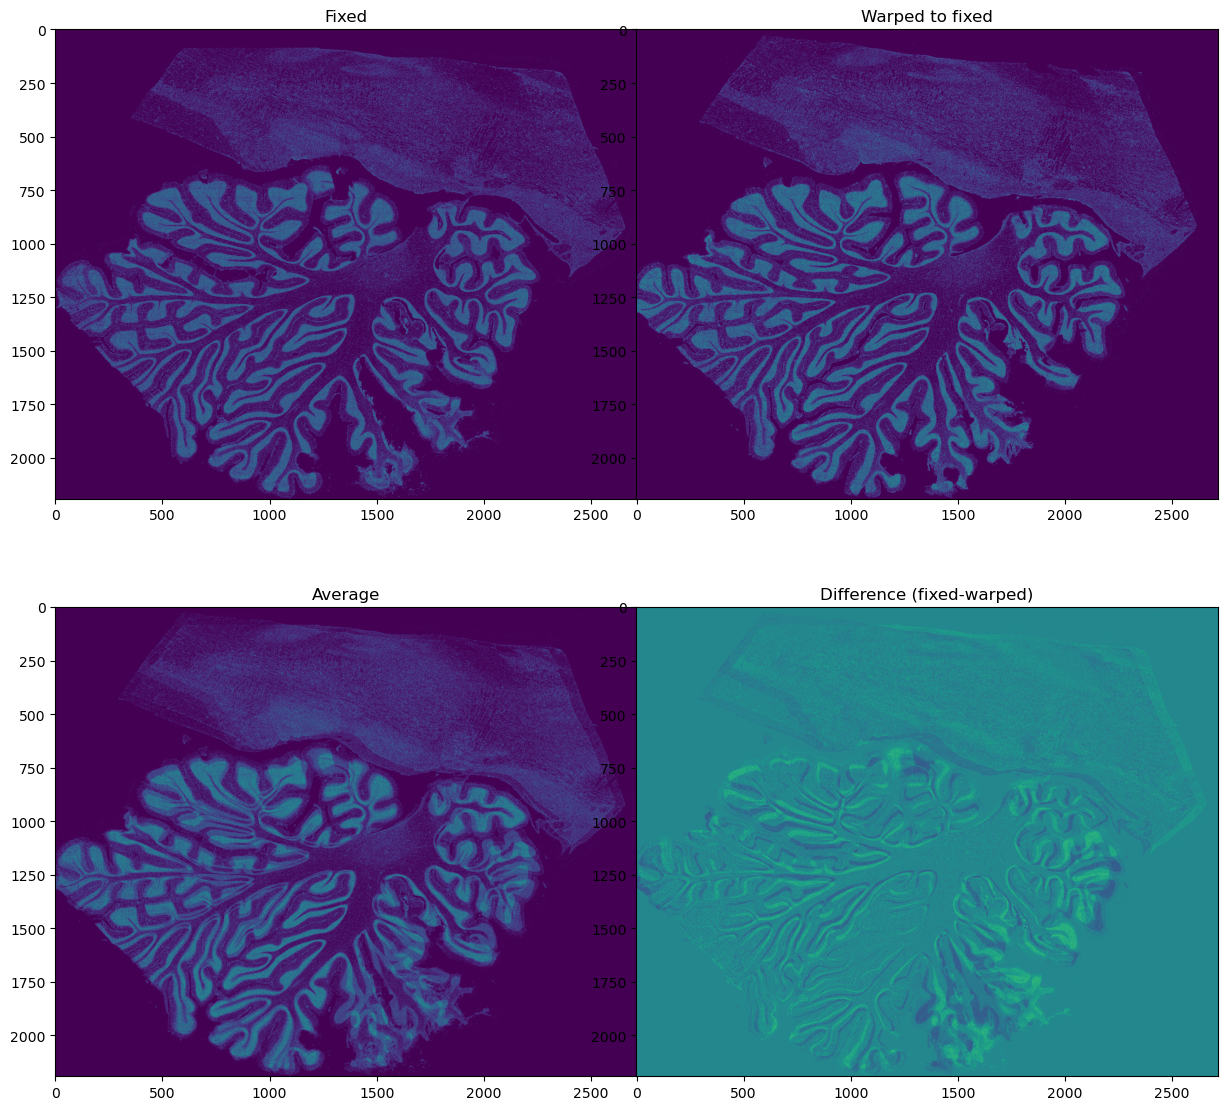

In [85]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.title('Fixed')
plt.imshow(fixed.numpy())
plt.subplot(2,2,2)
plt.title('Warped to fixed')
plt.imshow(mywarpedimage.numpy())
plt.subplot(2,2,3)
plt.title('Average')
plt.imshow(.5*(fixed.numpy()+mywarpedimage.numpy()))

plt.subplot(2,2,4)
plt.title('Difference (fixed-warped)')
plt.imshow((fixed.numpy()-mywarpedimage.numpy()))

plt.subplots_adjust(wspace=0, hspace=0)
# plt.

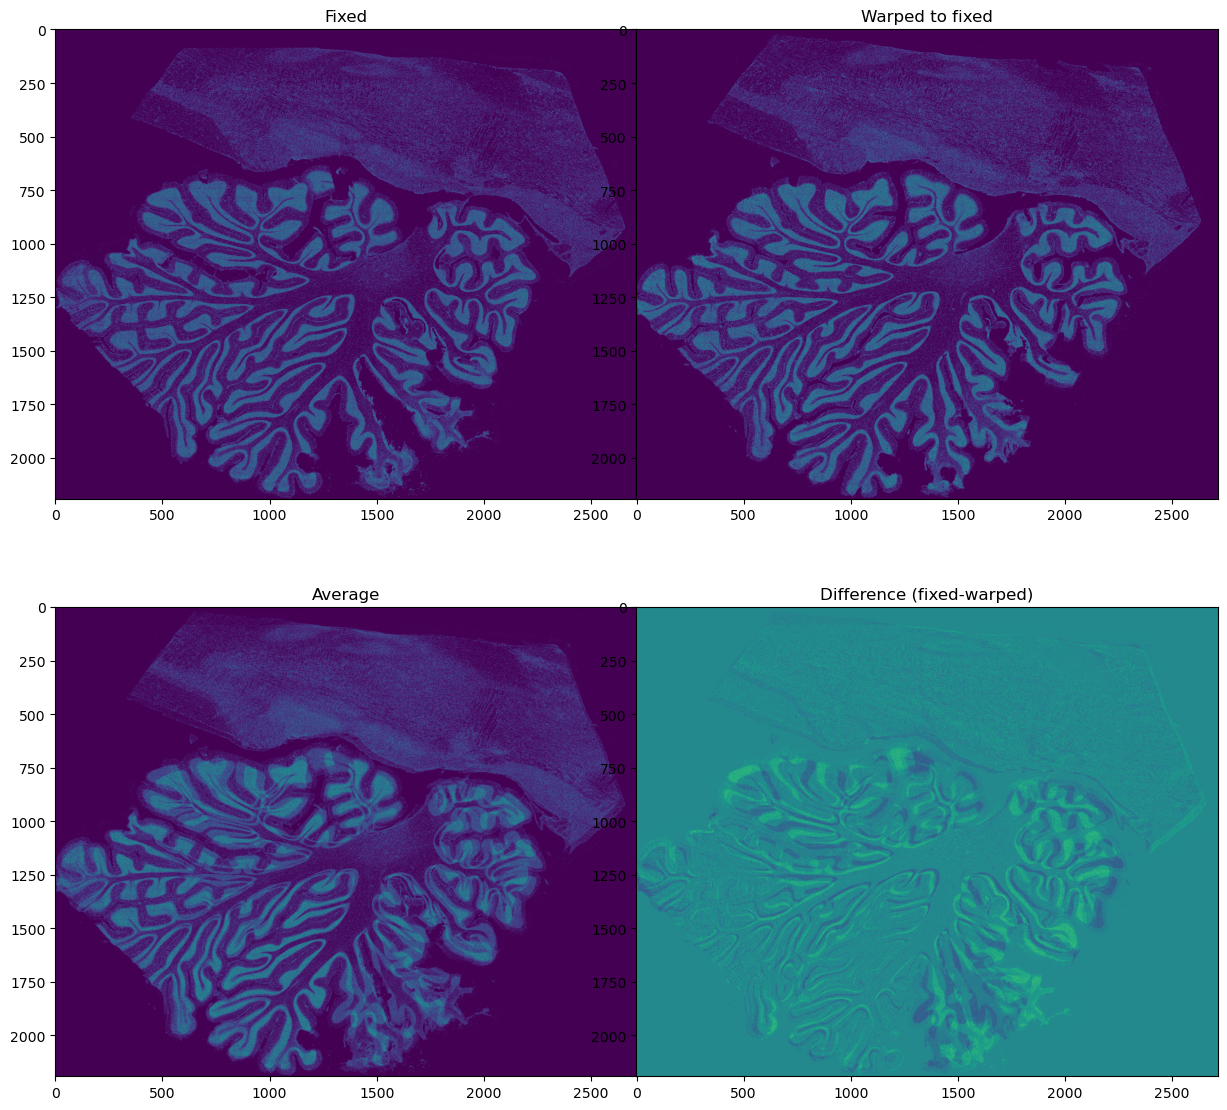

In [80]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.title('Fixed')
plt.imshow(fixed.numpy())
plt.subplot(2,2,2)
plt.title('Warped to fixed')
plt.imshow(mywarpedimage.numpy())
plt.subplot(2,2,3)
plt.title('Average')
plt.imshow(.5*(fixed.numpy()+mywarpedimage.numpy()))

plt.subplot(2,2,4)
plt.title('Difference (fixed-warped)')
plt.imshow((fixed.numpy()-mywarpedimage.numpy()))

plt.subplots_adjust(wspace=0, hspace=0)
# plt.